### 0. Imports

In [2]:
from squidpy import read_seqfish
import squidpy.graph as graph
import squidpy.plotting as pl

import scanpy as sc

%load_ext autoreload
%autoreload 2

# A. seqFISH

In [3]:
BASE_PATH = '/Users/anna.schaar/phd/datasets/seqfish/seqFISH-PLUS-master/'

### 1. Build spatial graphs

In [4]:
adata_ob = read_seqfish(BASE_PATH, "ob")
adata_svz = read_seqfish(BASE_PATH, "svz")
adata_ob

/Users/anna.schaar/opt/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2050 × 10000
    obs: 'index', 'louvain', 'Field of View', 'Cell ID', 'X', 'Y'
    obsm: 'spatial'

In [5]:
adata_svz_5 = adata_svz[adata_svz.obs["Field of View"] == 5].copy()
# use number of neighbors
graph.spatial_connectivity(adata_svz_5, n_neigh=10, coord_type='seqfish')

In [6]:
adata_svz_5

AnnData object with n_obs × n_vars = 281 × 10000
    obs: 'index', 'louvain', 'Field of View', 'Cell ID', 'X', 'Y', 'Region'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

### 2. Calculate centrality scores

In [7]:
graph.centrality_scores(adata_svz_5, cluster_key='louvain', connectivity_key='spatial_connectivities')

In [8]:
adata_svz_5

AnnData object with n_obs × n_vars = 281 × 10000
    obs: 'index', 'louvain', 'Field of View', 'Cell ID', 'X', 'Y', 'Region'
    uns: 'spatial_neighbors', 'louvain_centrality_scores'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

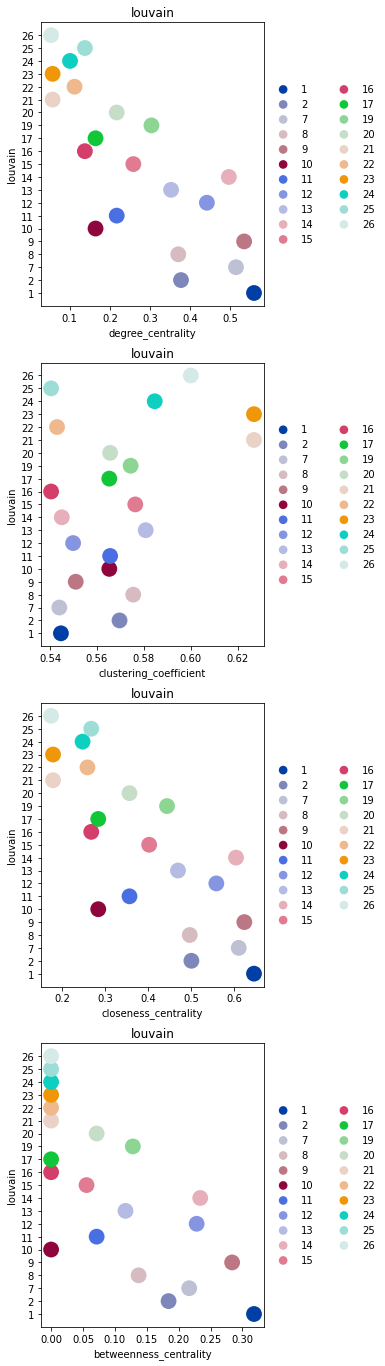

In [9]:
pl.centrality_scores(adata_svz_5, 'louvain')

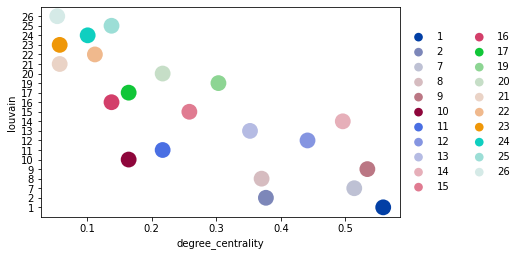

In [10]:
pl.centrality_scores(adata_svz_5, 'louvain', selected_score='degree_centrality')

### 3. Get interactions od clusters

In [11]:
graph.interaction_matrix(adata_svz_5, cluster_key='louvain', normalized=True)

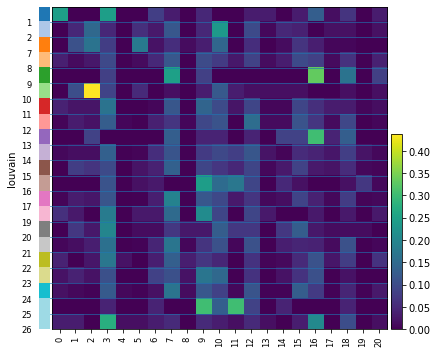

In [12]:
pl.interaction_matrix(adata_svz_5, 'louvain')

# B. Visium

In [13]:
adata = sc.datasets.visium_sge('V1_Mouse_Brain_Sagittal_Posterior_Section_2')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
#sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [15]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

In [17]:
adata

AnnData object with n_obs × n_vars = 3293 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [18]:
graph.spatial_connectivity(adata, obsm='spatial', n_rings=3)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


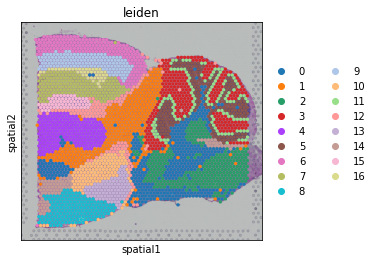

In [19]:
sc.pl.spatial(adata, color="leiden", size=1.5)

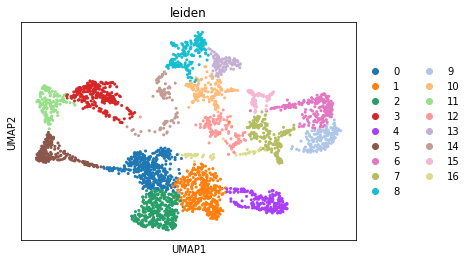

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata)
sc.pl.umap(adata, color='leiden')

In [21]:
graph.centrality_scores(adata,'leiden')

In [22]:
graph.interaction_matrix(adata,'leiden')

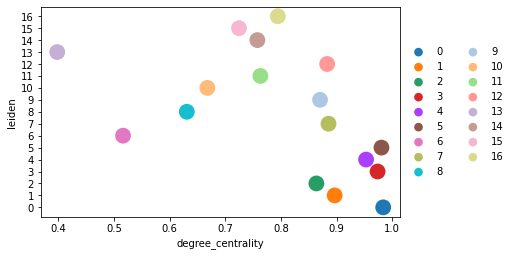

In [23]:
pl.centrality_scores(adata, 'leiden', selected_score='degree_centrality')

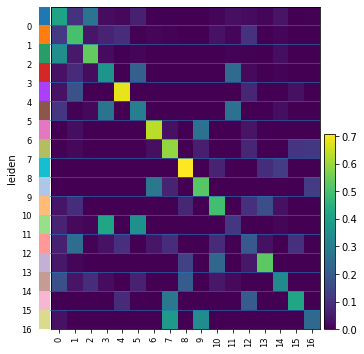

In [24]:
pl.interaction_matrix(adata, 'leiden')

# DEVELOPMENT STARTS HERE

## ligrec plotting

In [25]:
import sys  

from scipy.stats import pearsonr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as se
import anndata

First getting res of perm_test to run. This follows the example in the ligrec permutation notebook. 

In [26]:
adata = sc.datasets.paul15()
adata.var_names = [str(g).upper() for g in adata.var_names]
sc.pp.normalize_per_cell(adata)
adata.raw = adata.copy()

# out file from ligrec notebook needed
pvals = pd.read_csv('out/pvalues.csv')
pvals_clean = pvals.iloc[:, 11:]
pvals_clean.index = pd.MultiIndex.from_frame(pvals[['gene_a', 'gene_b']].astype('str'))
pvals_clean.columns = pd.MultiIndex.from_tuples(tuple(pvals_clean.columns.str.split('|')))

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [27]:
res = se.graph.perm_test(adata, "paul15_clusters", interactions=list(pvals_clean.index),
                        fdr_method=None, copy=True,
                        threshold=0.01, seed=0, n_perms=10000, n_jobs=1)

## Plotting dev starts here

In [28]:
# cluster_1 values that can be specified to be used as group in x axis
np.unique(list(res.means.columns.get_level_values('cluster_1')))

array(['10GMP', '11DC', '12Baso', '13Baso', '14Mo', '15Mo', '16Neu',
       '17Neu', '18Eos', '19Lymph', '1Ery', '2Ery', '3Ery', '4Ery',
       '5Ery', '6Ery', '7MEP', '8Mk', '9GMP'], dtype='<U7')

In [29]:
def ligrec(
    permutation_test_results,
    selected_cluster,
    level_1 = 'cluster_1',
    level_2 = 'cluster_2',
    ligand = 'source',
    receptor = 'target'
):
    # step 1: subsetting the res dataset to only include the selected cluster_1
    # this is how we subset based on cluster one 
    means = res.means.xs(selected_cluster, level=level_1, drop_level=False, axis=1)
    pvalues = res.pvalues.xs(selected_cluster, level=level_1, drop_level=False, axis=1)
    
    # step 2: joining multiindexing for axis labeling
    means.index = means.index.map('-'.join)
    means.columns = means.columns.map('|'.join)

    pvalues.index = pvalues.index.map('-'.join)
    pvalues.columns = pvalues.columns.map('|'.join)
    
    # step 3: transformation of pvalues (potentially means)
    #means = np.log2(means)
    pvalues = -np.log10(pvalues).fillna(0)
    
    # step 4: preparing adata object needed for DotPlot class in scanpy. 
    # ad.X is not used in the plot as we pass a dot_color_df and dot_size_df later
    idx = {f"{ligand}-{receptor}": pd.Categorical(pvalues.index, categories=pvalues.index)}

    var = pd.DataFrame(pvalues.columns, columns=[f"{level_1}|{level_2}"])
    var["index"] = var[f"{level_1}|{level_2}"]
    var = var.set_index("index")

    ad = anndata.AnnData(
        pvalues.values, 
        obs=idx,
        var=var
    )
    
    sc.pl.DotPlot(
        adata=ad,
        var_names=ad.var_names,
        groupby=f"{ligand}-{receptor}",
        dot_color_df=means,
        dot_size_df=pvalues
    ).legend(
        size_title='$-\log_{10} ~ P$',
        colorbar_title=f"mean ({ligand}, {receptor})"
    ).style(
        dot_max=0.03  # hacky way to achieve integer displying in dot legend
    ).show()

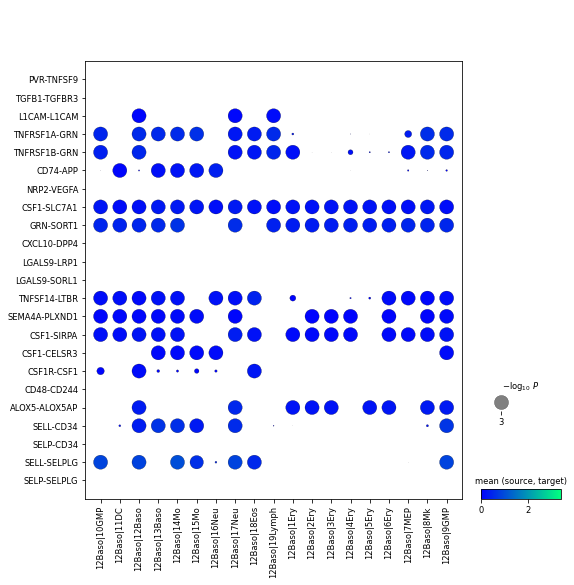

In [30]:
ligrec(
    permutation_test_results=res,
    selected_cluster='12Baso'
)